In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import load_dataset
from torch import nn
from tqdm import tqdm, trange
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from torch.utils.data import DataLoader
import pickle
from aiirw import AI_IRW


sns.set_style('white')

2023-02-16 10:55:41.807033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 10:55:42.819165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-16 10:55:42.819286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-16 10:55:42.819295: W tensorfl

In [7]:
tokenizer = AutoTokenizer.from_pretrained("fabriceyhc/bert-base-uncased-imdb")

model = AutoModelForSequenceClassification.from_pretrained("fabriceyhc/bert-base-uncased-imdb")
dataset = load_dataset("imdb")
out_dataset = load_dataset("sst2")

Found cached dataset imdb (/home/onyxia/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset sst2 (/home/onyxia/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
class LatentBert(nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.N = len(self.base_model.bert.encoder.layer)

    def to(self, device):
        self.base_model.to(device)
        return self

    def forward(self, x, return_class = False):
        x = self.base_model.bert.embeddings(x)
        latent_reps = torch.zeros((x.shape[0], x.shape[2],self.N)
        )
        for i, layer in enumerate(self.base_model.bert.encoder.layer) :
            x = layer(x)[0]
            latent_reps[:,:,i] = x[:,0,:] #Pooling is done by taking the hidden state of first token (cf Bert implementation)

        if return_class:
            x = self.base_model.bert.pooler(x)
            x = self.base_model.classifier(x)

            return torch.mean(latent_reps, axis=-1), torch.argmax(x, axis=-1)
            
        return torch.mean(latent_reps, axis=-1)

In [4]:
lb = LatentBert(base_model=model).to('cuda')

In [6]:
train_in_dl = DataLoader(dataset['train'], batch_size=8)

environ 14min

In [7]:
embds = []
labels = []
for batch in tqdm(train_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    labels.append(label.cpu().detach())

100%|██████████| 3125/3125 [14:35<00:00,  3.57it/s]


In [8]:
with open('embeddings_train.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_train.pkl', 'wb') as f:
    pickle.dump(labels, f)
    

In [5]:
ood_dl = DataLoader(dataset=out_dataset['test'], batch_size=16)

In [6]:
embds = []
labels = []
is_accurate = []
for batch in tqdm(ood_dl):
    data = batch['sentence']
    true_label = batch['label']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    pred = label.cpu().detach()
    labels.append(pred)
    is_accurate.append(true_label==pred)
    

100%|██████████| 114/114 [00:05<00:00, 21.34it/s]


In [7]:
with open('embeddings_ood_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_ood_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

In [9]:
test_in_dl = DataLoader(dataset['test'], batch_size=8)

environ 14 min

In [10]:
embds = []
labels = []
is_accurate
for batch in tqdm(test_in_dl):
    data = batch['text']
    tk_batch = tokenizer(data,return_tensors="pt", truncation=True, padding=True)['input_ids'].to('cuda')
    embd, label = lb.forward(tk_batch, return_class=True)
    embds.append(embd.cpu().detach())
    labels.append(label.cpu().detach())

100%|██████████| 3125/3125 [14:54<00:00,  3.50it/s]


In [11]:
with open('embeddings_test.pkl', 'wb') as f:
    pickle.dump(embds, f)

with open('labels_test.pkl', 'wb') as f:
    pickle.dump(labels, f)

## Loading

In [8]:
with open('embeddings_train.pkl', 'rb') as f:
    embd_train = pickle.load(f)

with open('labels_train.pkl', 'rb') as f:
    label_train = pickle.load(f)

In [9]:
with open('embeddings_ood_test.pkl', 'rb') as f:
    embd_ood = pickle.load(f)

with open('labels_ood_test.pkl', 'rb') as f:
    label_ood = pickle.load(f)

In [10]:
with open('embeddings_test.pkl', 'rb') as f:
    embd_test = pickle.load(f)

with open('labels_test.pkl', 'rb') as f:
    label_test = pickle.load(f)

In [11]:
label_train = torch.cat(label_train).numpy()
embd_train = torch.cat(embd_train).numpy()

train_distrib  = {l: embd_train[np.where(label_train==l)] for l in np.unique(label_train)}


In [12]:
label_test = torch.cat(label_test).numpy()
embd_test = torch.cat(embd_test).numpy()

test_distrib  = {l: embd_test[np.where(label_test==l)] for l in np.unique(label_test)}


In [13]:
label_ood_ = torch.cat(label_ood).numpy()
embd_ood_ = torch.cat(embd_ood).numpy()

ood_distrib  = {l: embd_ood_[np.where(label_ood_==l)] for l in np.unique(label_ood_)}


In [14]:
scores_ood = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=ood_distrib[0], n_dirs=200) ,AI_IRW(X=train_distrib[1], AI=True, X_test=ood_distrib[1], n_dirs=200)))

In [20]:
scores_test = np.concatenate((AI_IRW(X=train_distrib[0], AI=True, X_test=test_distrib[0], n_dirs=200, robust=True) ,AI_IRW(X=train_distrib[1], AI=True, X_test=test_distrib[1], n_dirs=200, robust=True)))

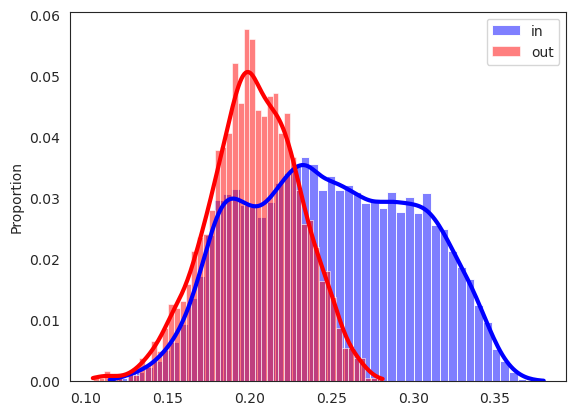

In [21]:
sns.histplot(scores_test, label='in', bins=50, kde=True, stat='proportion', color='blue',  line_kws={"lw":3})
sns.histplot(scores_ood, label='out', bins=50, kde=True, stat='proportion', color='red',  line_kws={"lw":3})
plt.legend()
plt.show()